In [39]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

from yellowbrick.classifier import ROCAUC

from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## 1. Set ups

### 1.1. Load models & scaler

In [40]:
# Load all sklearn models
with open("./model/all_sklearn.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
with open("./model/all_dp.pkl", "rb") as f:
    dp_models = pickle.load(f)

# Load input scaler
with open("./model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

### 1.2. Important functions

In [41]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

## 2. Process Test set

In [42]:
# load dataset
test_df = describe_dataset("./test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "C", "label"] = 0
test_df.loc[test_df["label"] == "H", "label"] = 1
test_df.loc[test_df["label"] == "L", "label"] = 2

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

## 2. Test set evaluation for all models

### 2.1. Sklearn models evaluation

In [54]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1, 2])
    testset_final_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.995828,0.995775,0.995775,0.995781,"[[234, 0, 0], [1, 240, 0], [2, 0, 233]]"
1,SVC,0.987793,0.987324,0.987324,0.987363,"[[234, 0, 0], [2, 239, 0], [7, 0, 228]]"
2,KNN,0.955544,0.949296,0.949296,0.949254,"[[233, 1, 0], [2, 239, 0], [33, 0, 202]]"
3,DTC,0.773783,0.767606,0.767606,0.765410,"[[127, 0, 107], [2, 238, 1], [55, 0, 180]]"
4,SGDC,0.981748,0.981690,0.981690,0.981707,"[[228, 6, 0], [3, 237, 1], [3, 0, 232]]"
5,NB,0.856763,0.842254,0.842254,0.838005,"[[148, 73, 13], [14, 227, 0], [4, 8, 223]]"
6,RF,0.922452,0.898592,0.898592,0.896179,"[[234, 0, 0], [0, 241, 0], [72, 0, 163]]"


### 2.2. Deep learning models

In [44]:
test_set_results = []

for name, model in dp_models.items():
    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1, 2])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

2022-11-28 10:56:43.727144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 10:56:43.847788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 10:56:43.976589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 10:56:44.117560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,3_layers,0.869224,0.847887,0.847887,0.843977,"[[146, 88, 0], [1, 240, 0], [19, 0, 216]]"
1,5_layers,0.934660,0.929577,0.929577,0.927795,"[[188, 16, 30], [1, 239, 1], [2, 0, 233]]"
2,7_layers_with_dropout,0.994461,0.994366,0.994366,0.994378,"[[234, 0, 0], [2, 239, 0], [2, 0, 233]]"
3,7_layers,0.935195,0.923944,0.923944,0.923033,"[[183, 51, 0], [1, 240, 0], [2, 0, 233]]"


### 2.3. Final Results

In [45]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.995828,0.995775,0.995775,0.995781,"[[234, 0, 0], [1, 240, 0], [2, 0, 233]]"
1,7_layers_with_dropout,0.994461,0.994366,0.994366,0.994378,"[[234, 0, 0], [2, 239, 0], [2, 0, 233]]"
2,SVC,0.987793,0.987324,0.987324,0.987363,"[[234, 0, 0], [2, 239, 0], [7, 0, 228]]"
3,SGDC,0.981748,0.981690,0.981690,0.981707,"[[228, 6, 0], [3, 237, 1], [3, 0, 232]]"
4,KNN,0.955544,0.949296,0.949296,0.949254,"[[233, 1, 0], [2, 239, 0], [33, 0, 202]]"
5,5_layers,0.934660,0.929577,0.929577,0.927795,"[[188, 16, 30], [1, 239, 1], [2, 0, 233]]"
6,7_layers,0.935195,0.923944,0.923944,0.923033,"[[183, 51, 0], [1, 240, 0], [2, 0, 233]]"
7,RF,0.922452,0.898592,0.898592,0.896179,"[[234, 0, 0], [0, 241, 0], [72, 0, 163]]"
8,3_layers,0.869224,0.847887,0.847887,0.843977,"[[146, 88, 0], [1, 240, 0], [19, 0, 216]]"
9,NB,0.856763,0.842254,0.842254,0.838005,"[[148, 73, 13], [14, 227, 0], [4, 8, 223]]"


## 3. Best model - ROC - Confusion Matrix

As we can see from the evaluation, the best model according to the F1 Score is the LR model.

In [55]:
best_model = sklearn_models["LR"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1, 2], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1, 2], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1, 2], average=None)

p_score, r_score, f1_score_result

(array([0.98734177, 1.        , 1.        ]),
 array([1.        , 0.99585062, 0.99148936]),
 array([0.99363057, 0.997921  , 0.9957265 ]))

In [58]:
(0.994 + 0.998 + 0.996) / 3

0.996

### 3.1. Confusion Matrix

<AxesSubplot:>

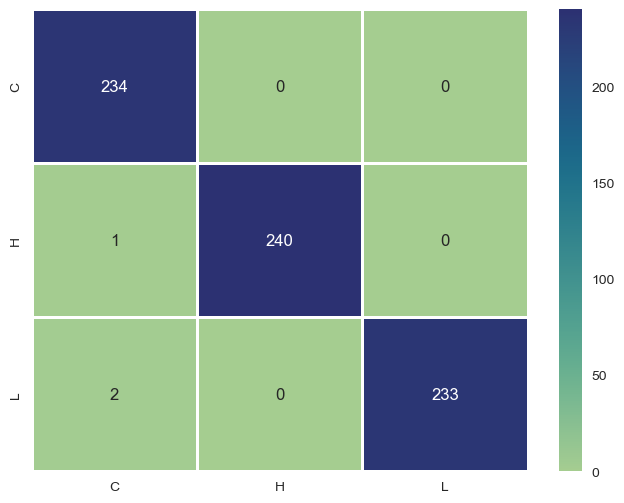

In [47]:
KNN_cm = eval_df[ eval_df["Model"] == 'LR' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["C", "H", "L"], columns=["C", "H", "L"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

### 3.3. F1 Score and Confidence correlation

In [48]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.01, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[0, 1, 2], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1, 2], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results


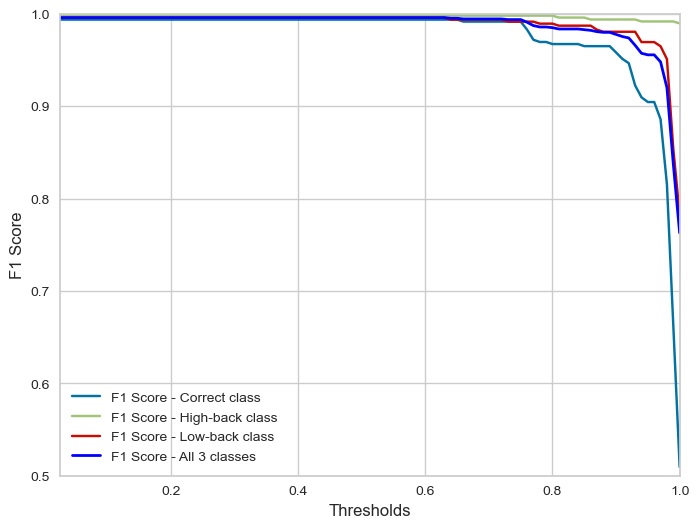

In [49]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
third_class = [ el[2] for el in f1_scores ]
all_classes = [ el[3] for el in f1_scores ]


fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - High-back class")
plt.plot(thresholds, third_class, label = "F1 Score - Low-back class")
plt.plot(thresholds, all_classes, label = "F1 Score - All 3 classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.5, 1])
plt.xlim([0.025, 1])
plt.xlabel("Thresholds", fontsize = 12)
plt.ylabel("F1 Score", fontsize = 12)
plt.show()

### 3.2. ROC curve

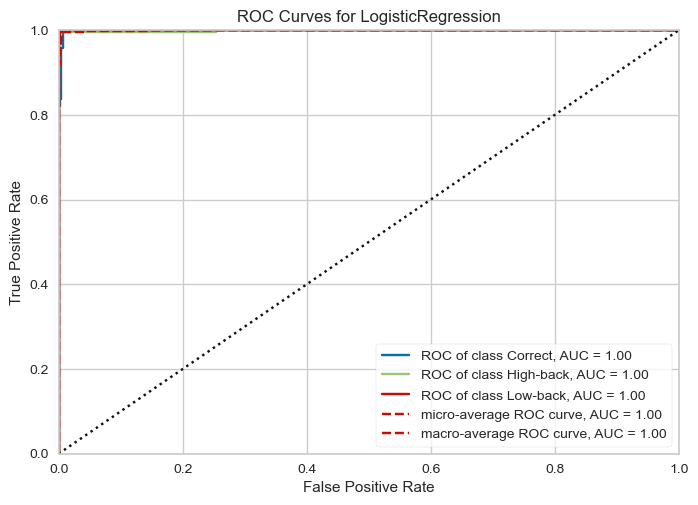

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
visualizer = ROCAUC(best_model, classes=["Correct", "High-back", "Low-back"])
visualizer.target_type_ = "multiclass"
visualizer.score(test_x, test_y)        
visualizer.show()                       